In [168]:
# import necessary modules
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime, timedelta
import pandas as pd
from scipy.spatial import distance_matrix
from matplotlib import cm as cm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from matplotlib import patches

In [79]:
#get the file path for loading, data file is under the same dir with the notebook
filename="20121015_00_ecmwf_ensemble_forecast.PRESSURE_LEVELS.EUR_LL10.120.pl.nc"
foldername="ECWMF Datasets"
filepath=os.path.join(os.path.dirname(os.getcwd()),foldername,filename)

# read the raw data and extract the needed data
# exrtact the value of Geopotential under the pressure of 500 hPA in the certain
Pressure_Levels_data = nc.Dataset(filepath,"r")
g = 9.80655
# get all the dimension value
nd_1,nd_2,nd_3,nd_4,nd_5 = Pressure_Levels_data.variables['Geopotential_isobaric'][:].shape
# get the necessary raw data
Geopotential_Isobaric_500 = Pressure_Levels_data.variables['Geopotential_isobaric'][0,:,7,:,:]/g
# reshape the dataset into form of (51,41*101)
Geopotential_Isobaric_500_reshaped = np.reshape(Geopotential_Isobaric_500,(nd_2, nd_4 * nd_5))
# prepare the longitude and latitude value for contour
longitude = Pressure_Levels_data['lon'][:]
latitude = Pressure_Levels_data['lat'][:]
(lon, lat) = np.meshgrid(longitude, latitude)

#get the time variable
times=Pressure_Levels_data.variables["time"]
#get the time number
arrDateEnd=nc.num2date(times[:],units=times.units)
#get the time in date format
dateEndDate = datetime.date(arrDateEnd[0]).strftime("%d %b %Y")
dateEndMin = datetime.date(arrDateEnd[0]).strftime("%H:%M")
dateStart=datetime.date(arrDateEnd[0])-timedelta(hours=120)
dateStartDate=dateStart.strftime("%d %b %Y")
dateStartMin=dateStart.strftime("%H:%M")

In [160]:
def find_nearest(array, value):
    posv=np.asarray(array[array>=0])
    negv=np.asarray(array[array<0])
    if(value<array.min() or value>array.max()):
        print("The given value is out of range")
    elif value<0:       
        return np.abs(negv - value).argmin()
    else:
        return np.abs(posv - value).argmin() + negv.shape[0]

In [161]:
def locate_region(longitude,latitude,point1,point2):
    pt1=np.asarray(point1)
    pt2=np.asarray(point2)
    
    pt1XIdx=find_nearest(longitude,pt1[0])
    pt1YIdx=find_nearest(latitude,pt1[1])
    pt2XIdx=find_nearest(longitude,pt2[0])
    pt2YIdx=find_nearest(latitude,pt2[1])
    
    long = longitude[pt1XIdx:pt2XIdx+1]
    lati = latitude[pt2YIdx:pt1YIdx+1]
    
    return np.meshgrid(long, lati)

In [162]:
def slice_data(data,point1,point2):
    pt1=np.asarray(point1)
    pt2=np.asarray(point2)
    
    pt1XIdx=find_nearest(longitude,pt1[0])
    pt1YIdx=find_nearest(latitude,pt1[1])
    pt2XIdx=find_nearest(longitude,pt2[0])
    pt2YIdx=find_nearest(latitude,pt2[1])
    
    newdata=data[:,pt2YIdx:pt1YIdx+1,pt1XIdx:pt2XIdx+1]
    
    return newdata

In [163]:
new = slice_data(Geopotential_Isobaric_500,(-20,40),(30,60))

In [164]:
a,b=locate_region(longitude,latitude,(-20,40),(30,60))

In [184]:
def draw_patches(ax,point1,point2,point3,point4,edgecolor):
    # Fill two polygon shapes
    patches = []

    rect = np.array([point1,point2,point3,point4])
    patches.append(Polygon(rect))

    ax.add_collection(PatchCollection(patches, facecolor='None', edgecolor=edgecolor, linewidths=1.5,zorder=zorder))

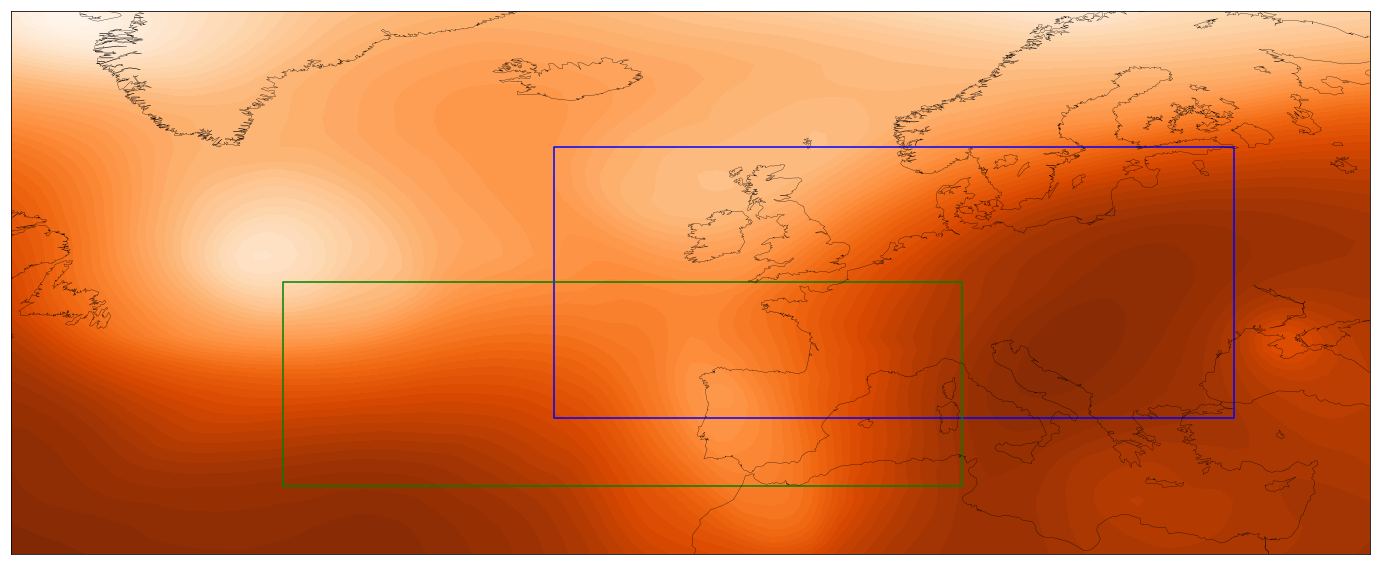

In [183]:
fig=plt.figure(figsize=(30,10))
ax=plt.gca()
map = Basemap(projection ='cyl',llcrnrlat = latitude[-1],urcrnrlat = latitude[0],resolution ='l', llcrnrlon = longitude[0], urcrnrlon = longitude[-1])
map.drawcoastlines(linewidth = 0.3)
map.contourf(lon, lat, Geopotential_Isobaric_500[5],cmap = 'Oranges',levels=50)
draw_patches(ax,[-20,40],[-20,60],[30,60],[30,40],'b')
draw_patches(ax,[-40,35],[-40,50],[10,50],[10,35],'g')